In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from nets import *
from cfgs import *
from data import *
from trainer import *
from payment_utils import get_payment


In [3]:
%matplotlib inline
save_plot = False
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
D = 201

# v1, v2を[0, 1]の範囲で生成
x = np.linspace(0, 1.0, D)

# v3を複数の値でサンプリング（3次元可視化のため）
c = 0.5
v3_values = np.linspace(0, c, 5)  # v3を0, c/4, c/2, 3c/4, cの5つの値でサンプリング
print(f'v3_values: {v3_values}')

cfg = additive_1x3_constrained_c0_5_config.cfg
cfg.test.batch_size = D
cfg.test.save_output = True


v3_values: [0.    0.125 0.25  0.375 0.5  ]


In [4]:
Net = constrained_additive_net.Net
Generator = constrained_3item_generator.Generator
Trainer = constrained_trainer.Trainer


In [5]:
# 各v3値に対してテストデータを生成し、推論を実行
net = Net(cfg, "test")
m = Trainer(cfg, "test", net)

# 各v3値での結果を保存
alloc_dict = {}
pay_dict = {}

for v3_val in v3_values:
    # 3財のテストデータを生成: [v1, v2, v3]
    X_tst = np.stack([v.flatten() for v in np.meshgrid(x, x)], axis=-1)
    # v3を固定値で追加
    X_tst = np.concatenate([X_tst, np.full((X_tst.shape[0], 1), v3_val)], axis=-1)
    
    # 推論を実行
    generator = Generator(cfg, 'test', X_tst)
    cfg.test.num_batches = int(X_tst.shape[0]/cfg.test.batch_size)
    m.test(generator)
    
    # 結果を読み込み
    alloc = np.load(os.path.join(cfg.dir_name, "alloc_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D, D, 3)
    pay = np.load(os.path.join(cfg.dir_name, "pay_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D, D)
    
    alloc_dict[v3_val] = alloc
    pay_dict[v3_val] = pay
    print(f"Completed v3 = {{v3_val:.2f}}")


2025-11-12 21:01:58,819:INFO:TEST ALL-200000: t = 0.1527, Net_Loss: -0.276138, Revenue: 0.276138, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 5.286036
2025-11-12 21:01:58,985:INFO:TEST ALL-200000: t = 0.1619, Net_Loss: -0.617390, Revenue: 0.617390, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 5.286036


Completed v3 = {v3_val:.2f}
Completed v3 = {v3_val:.2f}


2025-11-12 21:01:59,183:INFO:TEST ALL-200000: t = 0.1918, Net_Loss: -0.716470, Revenue: 0.716470, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 5.286036
2025-11-12 21:01:59,377:INFO:TEST ALL-200000: t = 0.1891, Net_Loss: -0.802376, Revenue: 0.802376, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 5.286036


Completed v3 = {v3_val:.2f}
Completed v3 = {v3_val:.2f}


2025-11-12 21:01:59,586:INFO:TEST ALL-200000: t = 0.2044, Net_Loss: -0.872066, Revenue: 0.872066, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 5.286036


Completed v3 = {v3_val:.2f}


In [6]:
# データは既に読み込まれているので、ここでは何もしない
# alloc_dictとpay_dictに各v3値での結果が保存されている


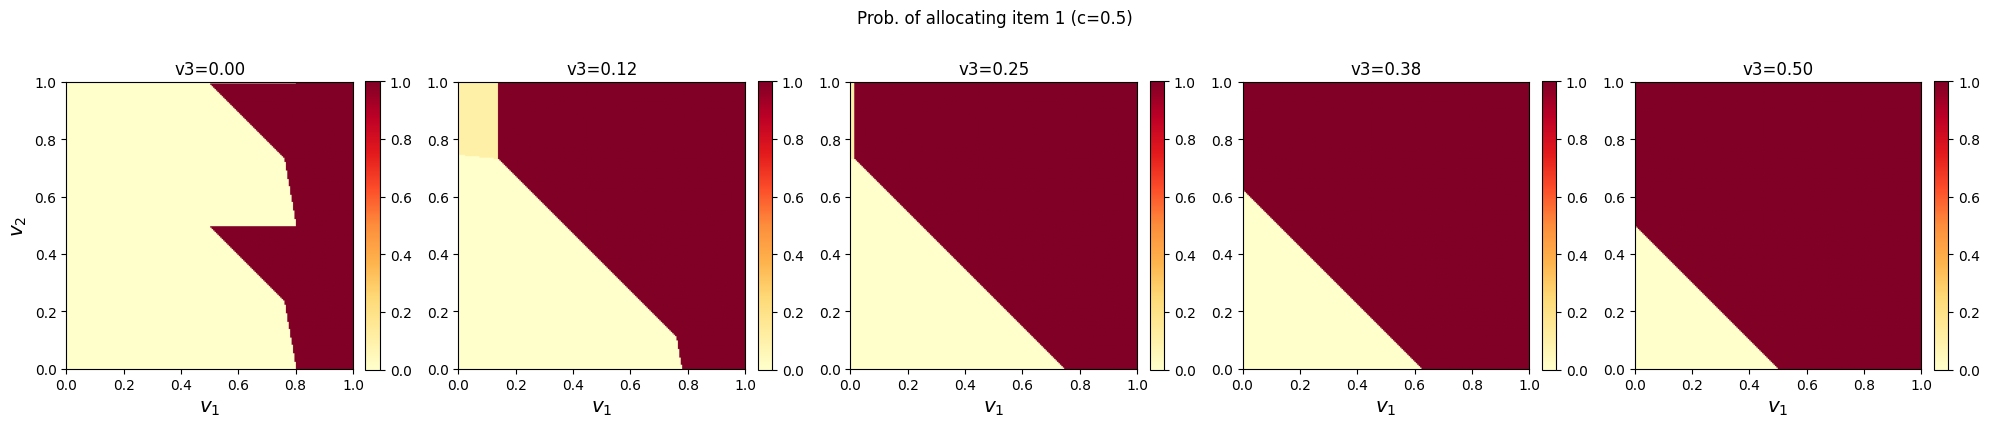

In [7]:
# 財1の配分確率を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(alloc[::-1, :, 0], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Prob. of allocating item 1 (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'alloc1_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


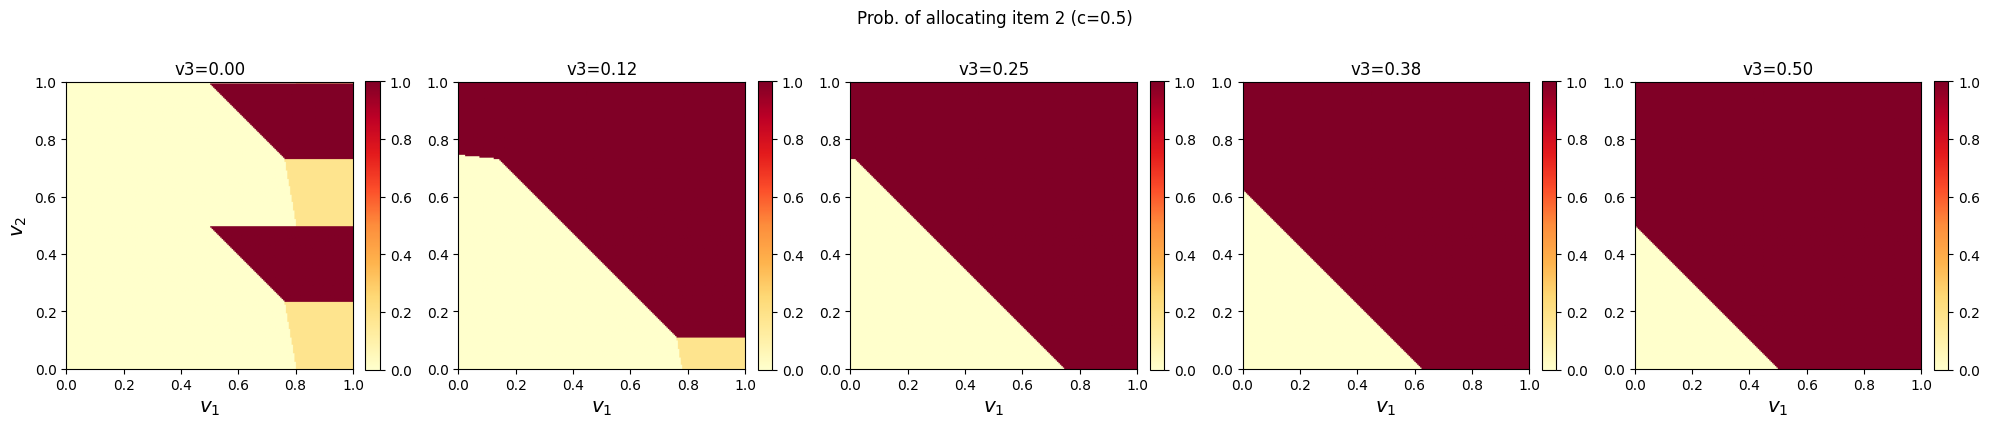

In [8]:
# 財2の配分確率を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(alloc[::-1, :, 1], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Prob. of allocating item 2 (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'alloc2_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


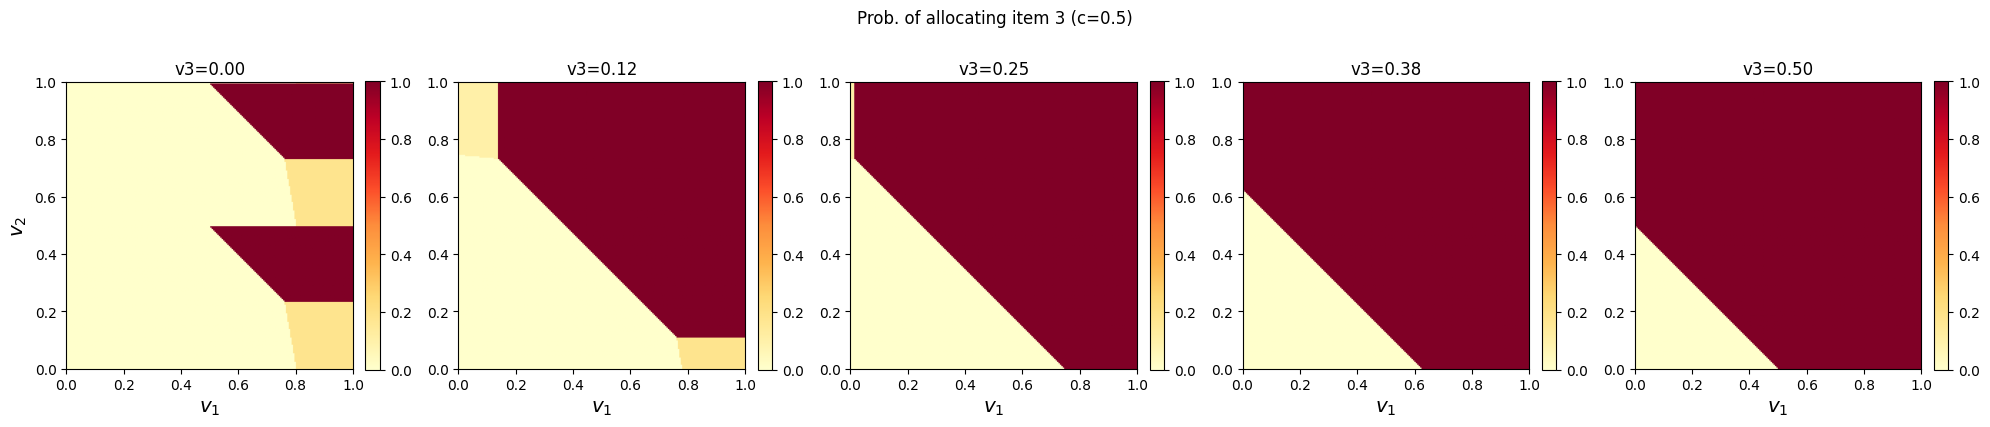

In [9]:
# 財3の配分確率を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(alloc[::-1, :, 2], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Prob. of allocating item 3 (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'alloc3_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


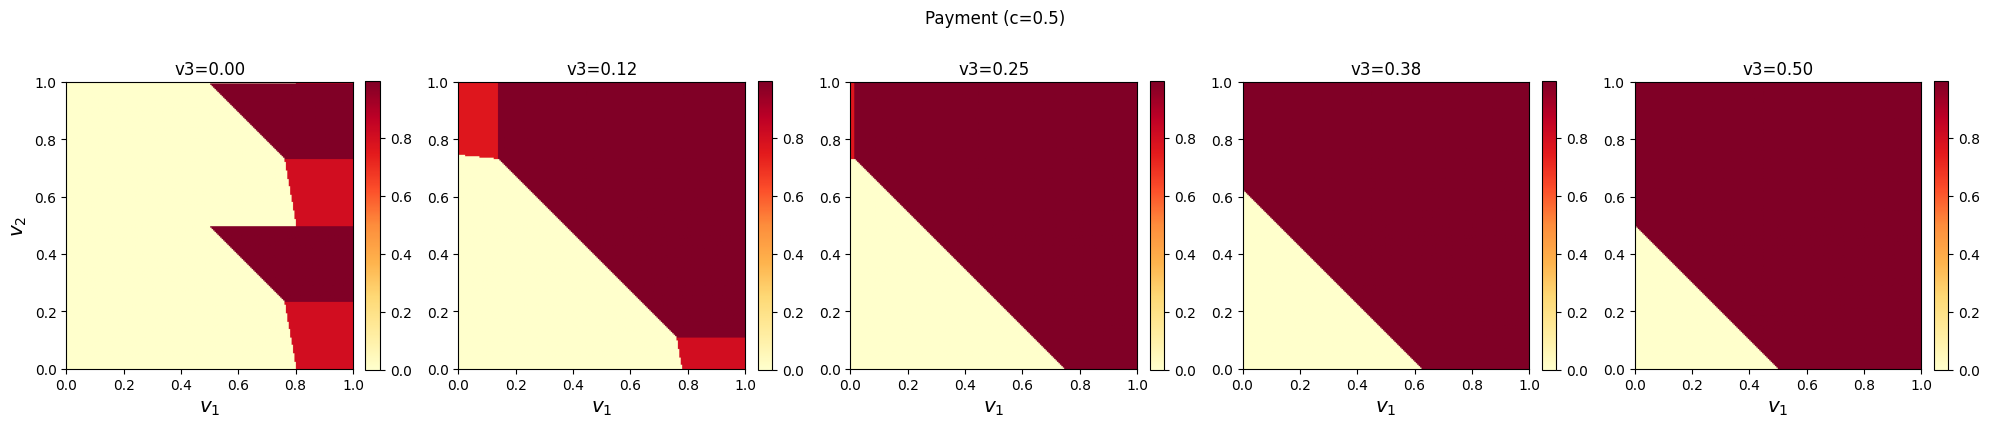

In [10]:
# Paymentを複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    pay = pay_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(pay[::-1, :], extent=[0, 1, 0, 1], cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Payment (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'pay_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


In [11]:
# 制約違反の確認（各v3値に対して）
print("Constraint Violation Statistics for each v3:")
for v3_val in v3_values:
    alloc = alloc_dict[v3_val]
    # 下界: max(0, alloc1 + alloc2 - 1) <= alloc3
    # 上界: alloc3 <= min(alloc1, alloc2)
    lower_bound = np.maximum(0, alloc[:, :, 0] + alloc[:, :, 1] - 1)
    upper_bound = np.minimum(alloc[:, :, 0], alloc[:, :, 1])
    lower_violation = np.maximum(0, lower_bound - alloc[:, :, 2])
    upper_violation = np.maximum(0, alloc[:, :, 2] - upper_bound)
    constraint_violation = lower_violation + upper_violation
    
    print(f"\nv3 = {{v3_val:.2f}}:")
    print(f"  Min: {{np.min(constraint_violation):.6f}}")
    print(f"  Max: {{np.max(constraint_violation):.6f}}")
    print(f"  Mean: {{np.mean(constraint_violation):.6f}}")
    print(f"  Number of violations: {{np.sum(constraint_violation > 1e-6)}}")


Constraint Violation Statistics for each v3:

v3 = {v3_val:.2f}:
  Min: {np.min(constraint_violation):.6f}
  Max: {np.max(constraint_violation):.6f}
  Mean: {np.mean(constraint_violation):.6f}
  Number of violations: {np.sum(constraint_violation > 1e-6)}

v3 = {v3_val:.2f}:
  Min: {np.min(constraint_violation):.6f}
  Max: {np.max(constraint_violation):.6f}
  Mean: {np.mean(constraint_violation):.6f}
  Number of violations: {np.sum(constraint_violation > 1e-6)}

v3 = {v3_val:.2f}:
  Min: {np.min(constraint_violation):.6f}
  Max: {np.max(constraint_violation):.6f}
  Mean: {np.mean(constraint_violation):.6f}
  Number of violations: {np.sum(constraint_violation > 1e-6)}

v3 = {v3_val:.2f}:
  Min: {np.min(constraint_violation):.6f}
  Max: {np.max(constraint_violation):.6f}
  Mean: {np.mean(constraint_violation):.6f}
  Number of violations: {np.sum(constraint_violation > 1e-6)}

v3 = {v3_val:.2f}:
  Min: {np.min(constraint_violation):.6f}
  Max: {np.max(constraint_violation):.6f}
  Mean: {np

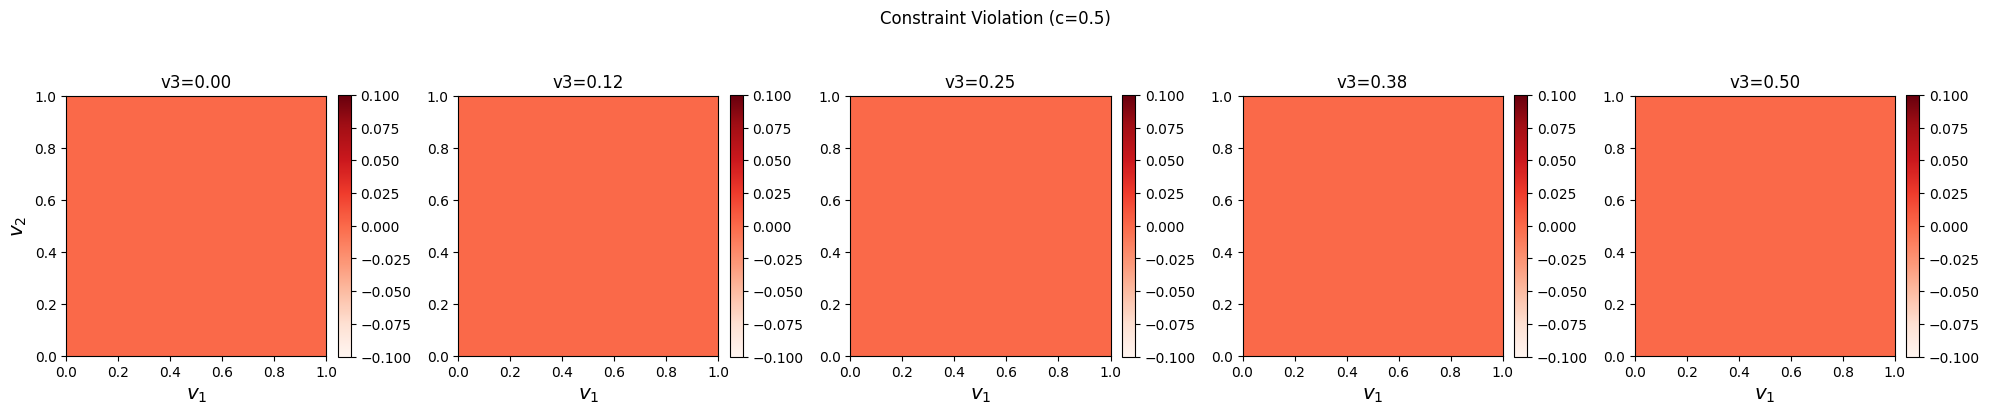

In [12]:
# 制約違反を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    lower_bound = np.maximum(0, alloc[:, :, 0] + alloc[:, :, 1] - 1)
    upper_bound = np.minimum(alloc[:, :, 0], alloc[:, :, 1])
    lower_violation = np.maximum(0, lower_bound - alloc[:, :, 2])
    upper_violation = np.maximum(0, alloc[:, :, 2] - upper_bound)
    constraint_violation = lower_violation + upper_violation
    
    ax = axes[idx]
    img = ax.imshow(constraint_violation[::-1, :], extent=[0, 1, 0, 1], cmap='Reds')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Constraint Violation (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'constraint_violation_3d.pdf'), bbox_inches='tight', pad_inches=0.05)
